# DiploDatos Kaggle Competition

Presentamos un código creado como ejemplo de base para la competición.

Deben:

- Explorar los datos y aprender de ellos.
- Probar diferentes modelos y ver cuáles ajustan mejor dado los datos.
- **Obtener una accuracy mejor que la que se presenta en este ejemplo.**
- Tratar de obtener la accuracy más alta posible!
- Discutir la elección de modelo.

El análisis exploratorio y el preprocesamiento de los datos queda a libertad de cada grupo y no deben quedarse con este simple ejemplo.

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn import ensemble

from sklearn import linear_model
from sklearn.svm import SVC
from sklearn.svm import NuSVC
from sklearn.svm import LinearSVC

from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

In [19]:
df = pd.read_csv('train.csv')
print(df.shape)
print(df.describe())

(7823, 14)
       PassengerId          Age   RoomService     FoodCourt  ShoppingMall  \
count  7823.000000  7661.000000   7669.000000   7668.000000   7635.000000   
mean   4345.691039    28.879389    226.078237    455.643062    172.600393   
std    2504.576803    14.461548    679.180148   1621.290107    597.923749   
min       0.000000     0.000000      0.000000      0.000000      0.000000   
25%    2182.500000    19.000000      0.000000      0.000000      0.000000   
50%    4345.000000    27.000000      0.000000      0.000000      0.000000   
75%    6515.500000    38.000000     44.000000     69.000000     28.000000   
max    8692.000000    79.000000  14327.000000  29813.000000  23492.000000   

                Spa        VRDeck  Transported  
count   7665.000000   7654.000000  7823.000000  
mean     305.023222    295.476744     0.506711  
std     1133.423579   1093.485752     0.499987  
min        0.000000      0.000000     0.000000  
25%        0.000000      0.000000     0.000000  
5

In [20]:
# data.isna() devuelve una matriz de booleanos en la que cada posicion indica si ese valor esta perdido o no. Hacer .sum() suma sobre los valores
# True de esa matriz y haciendo ascending=False le pedimos que nos de las columnas con mas valores perdidos
nans = df.isna().sum().sort_values(ascending=False)
print(nans[nans!=0]/df.shape[0]) #Aca nos da la proporcion de valores perdidos de cada columna 

CryoSleep       0.025054
ShoppingMall    0.024032
Cabin           0.023520
VIP             0.023520
Name            0.023520
HomePlanet      0.022881
VRDeck          0.021603
Age             0.020708
Destination     0.020453
Spa             0.020197
FoodCourt       0.019813
RoomService     0.019686
dtype: float64


El porcentaje de datos perdidos en cada columna es muy bajo, asi que puedo eliminar estos datos sin perder demasiadas instancias.

In [21]:
df = df.dropna(axis=0, subset=['CryoSleep', 'VIP', 'HomePlanet', 'Destination'])
print(len(df.index)) #perdimos 600 datos, lo cual representa el 9% de los datos

7123


In [22]:
imputer_cols = ["Age", "FoodCourt", "ShoppingMall", "Spa", "VRDeck" ,"RoomService"] #Imputo los datos faltantes de las columnas correspondientes a
                                                                                    #los "amenities" de la nave    
imputer = SimpleImputer(strategy="median")                                          #Imputo por la mediana  
df[imputer_cols] = imputer.fit_transform(df[imputer_cols])

<Figure size 720x720 with 0 Axes>

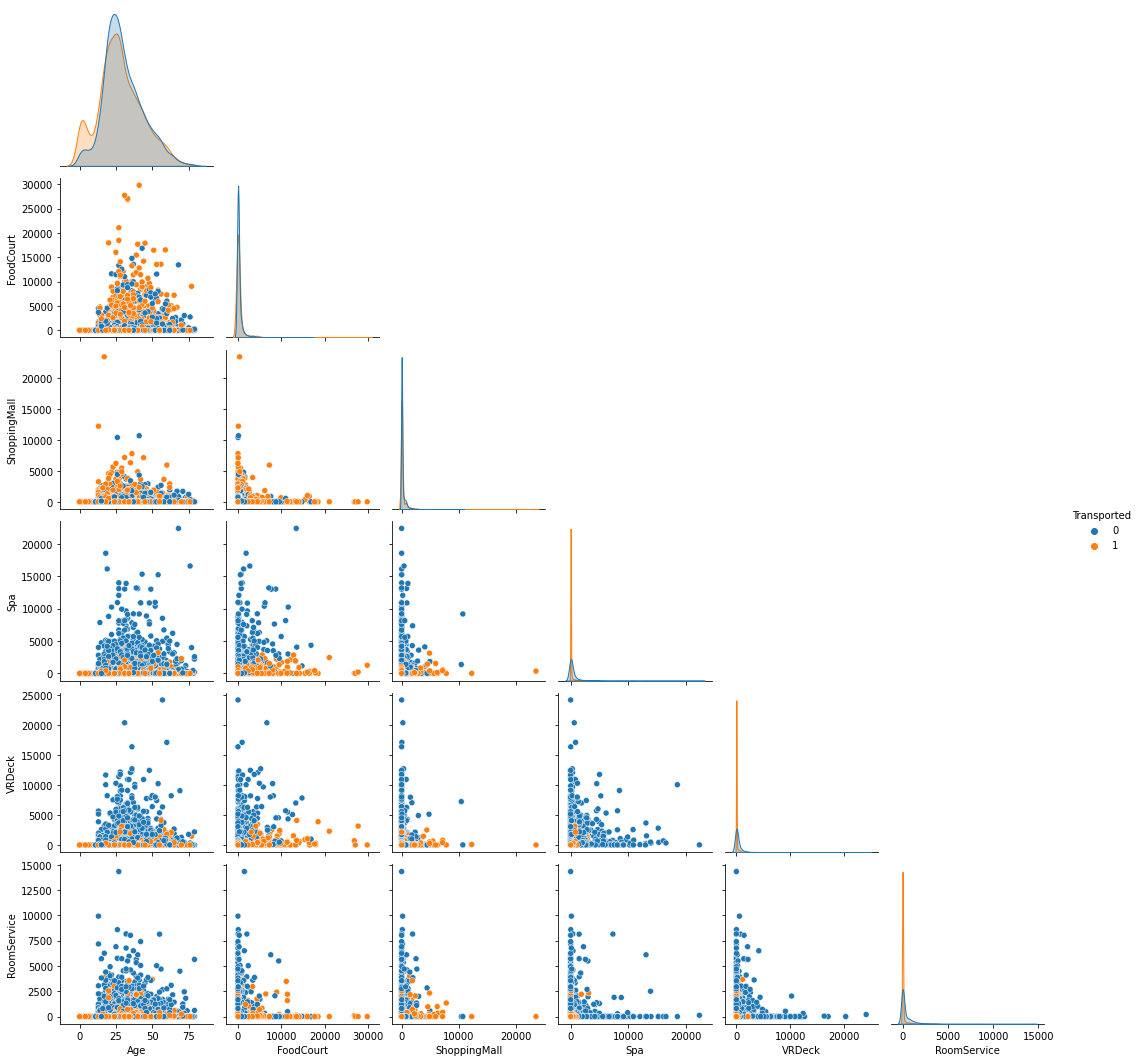

In [33]:
col = ['Age', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'RoomService']
dat = df[col]
dat = dat.join(df.Transported)
fig = plt.figure(figsize=(10,10))
sns.pairplot(dat, hue='Transported', corner=True)
#plt.savefig('pairplot_6.jpg', bbox_inches = 'tight')

<AxesSubplot:ylabel='Sueño criogénico'>

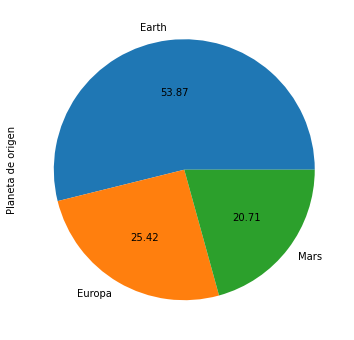

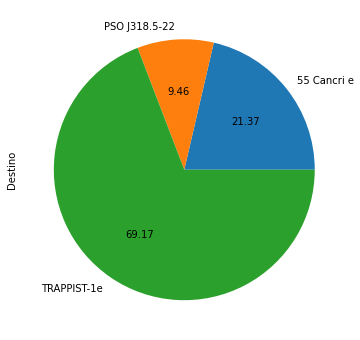

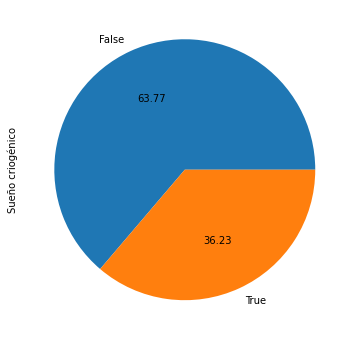

In [30]:
fig = plt.figure(figsize = (6,6))
df.groupby('HomePlanet').size().plot(kind='pie', ylabel = 'Planeta de origen', autopct='%.2f')

fig = plt.figure(figsize = (6,6))
df.groupby('Destination').size().plot(kind='pie', ylabel = 'Destino', autopct='%.2f')

fig = plt.figure(figsize = (6,6))
df.groupby('CryoSleep').size().plot(kind='pie', ylabel = 'Sueño criogénico', autopct='%.2f')

In [34]:
#Separamos el target de las features
y = df.Transported 
X = df.drop('Transported',axis=1)
X

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,3430,Europa,False,C/123/P,TRAPPIST-1e,57.0,False,0.0,3859.0,13.0,195.0,3874.0,Azhah Tronsive
3,6463,Earth,False,F/1420/P,TRAPPIST-1e,43.0,False,142.0,1208.0,0.0,0.0,204.0,Landa Grifford
4,85,Earth,False,G/9/P,TRAPPIST-1e,19.0,False,0.0,0.0,670.0,1.0,34.0,Gracy Dunnisey
5,7586,Earth,False,F/1553/S,PSO J318.5-22,23.0,False,90.0,4.0,0.0,7.0,588.0,Benda Dickley
6,2358,Mars,False,E/153/P,TRAPPIST-1e,29.0,False,834.0,0.0,28.0,117.0,41.0,Quid Dutte
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7817,2204,Earth,True,G/379/P,TRAPPIST-1e,24.0,False,0.0,0.0,0.0,0.0,0.0,Dorene Boyersons
7819,2693,Earth,False,G/459/S,TRAPPIST-1e,44.0,False,0.0,0.0,744.0,62.0,3.0,Gabrie Reenez
7820,8076,Mars,True,F/1772/P,TRAPPIST-1e,55.0,False,0.0,0.0,0.0,0.0,0.0,Panzel Ruity
7821,3829,Earth,False,E/253/P,TRAPPIST-1e,15.0,False,0.0,840.0,123.0,0.0,20.0,Belly Weavesend


### Algún análisis exploratorio que permita tomar decisiones sobre las variabes a usar, transformaciones de variables, tratamiento de los datos faltantes, etc. etc.

In [35]:
# elijo y transformo algunas variables (en su análisis fundamente sus decisiones)
for var in X:
    if X[var].dtype == 'object':
        unique_cases = X[var].unique() #devuelve valores unicos en la columna (valores no repetidos)
        if len(unique_cases) > 5:        
            print(var)      
            X.drop(var, inplace=True, axis=1)   #si la cantidad de casos unicos es mayor a 5, tira esa columna

passengerId = X.PassengerId
X.drop('PassengerId',axis=1,inplace=True)   #tira la columna de identidad de pasajeros

print(X.columns)
label_cols = ["HomePlanet", "CryoSleep", "Destination" ,"VIP"]    

for col in label_cols:
    X[col] = X[col].astype(str)                   #convierte a string los valores de las columnas
    X[col] = LabelEncoder().fit_transform(X[col]) #hace label encoder sobre las columnas 

x_names = X.columns                      
X = StandardScaler().fit_transform(X)     #aplico StandardScaler a las columnas 
X = pd.DataFrame(X, columns=x_names)
X
# al final tengo una base de datos con las variables categoricas con encoding y escaladas 

Cabin
Name
Index(['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'RoomService',
       'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'],
      dtype='object')


,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,0.415871,-0.753825,0.634447,1.966456,-0.158239,-0.329135,2.087838,-0.260822,-0.094191,3.295125
1,-0.838257,-0.753825,0.634447,0.989064,-0.158239,-0.117089,0.462345,-0.282124,-0.267174,-0.078533
2,-0.838257,-0.753825,0.634447,-0.686463,-0.158239,-0.329135,-0.278354,0.815765,-0.266287,-0.234806
3,-0.838257,-0.753825,-0.581036,-0.407209,-0.158239,-0.194740,-0.275902,-0.282124,-0.260964,0.274460
4,1.670000,-0.753825,0.634447,0.011673,-0.158239,0.916259,-0.278354,-0.236242,-0.163384,-0.228371
...,...,...,...,...,...,...,...,...,...,...
7118,-0.838257,1.326568,0.634447,-0.337395,-0.158239,-0.329135,-0.278354,-0.282124,-0.267174,-0.266061
7119,-0.838257,-0.753825,0.634447,1.058878,-0.158239,-0.329135,-0.278354,0.937025,-0.212174,-0.263303
7120,1.670000,1.326568,0.634447,1.826828,-0.158239,-0.329135,-0.278354,-0.282124,-0.267174,-0.266061
7121,-0.838257,-0.753825,0.634447,-0.965718,-0.158239,-0.329135,0.236702,-0.080571,-0.267174,-0.247676


In [36]:
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state = 8)

### Planteo modelos
Tienen que elegir los 2 mejores modelos así que prueben con varios.

In [48]:
clfs = [ensemble.RandomForestClassifier(), linear_model.LogisticRegressionCV(solver='sag',max_iter=3000), linear_model.SGDClassifier(), 
        SVC(kernel='poly'), NuSVC(kernel='poly'), LinearSVC(max_iter=50000), DecisionTreeClassifier(criterion='entropy'), 
        ExtraTreeClassifier(), XGBClassifier()]

scores = [None]*9
times = [None]*9
for clf in clfs:
    start_time = time.time()
    clf_fit = clf.fit(x_train,y_train)
    score = clf_fit.score(x_test,y_test)
    scores[clfs.index(clf)] = score
    times[clfs.index(clf)] = time.time() - start_time
    print("--- %s seconds ---" % (time.time() - start_time))
    
    train_predictions = clf_fit.predict(x_train)
    accuracy = accuracy_score(y_train, train_predictions)
    print(f"Accuracy train {clf}: %.2f%%" % (accuracy * 100.0))
    
    train_predictions = clf.predict(x_test)
    accuracy = accuracy_score(y_test, train_predictions)
    print(f"Accuracy test {clf}: %.2f%%" % (accuracy * 100.0))
    
    print('La accuracy de', clf, 'es', score)

--- 0.6905317306518555 seconds ---
Accuracy train RandomForestClassifier(): 93.45%
Accuracy test RandomForestClassifier(): 78.60%
La accuracy de RandomForestClassifier() es 0.7859649122807018
--- 0.9968287944793701 seconds ---
Accuracy train LogisticRegressionCV(max_iter=3000, solver='sag'): 78.40%
Accuracy test LogisticRegressionCV(max_iter=3000, solver='sag'): 77.19%
La accuracy de LogisticRegressionCV(max_iter=3000, solver='sag') es 0.7719298245614035
--- 0.04894661903381348 seconds ---
Accuracy train SGDClassifier(): 77.11%
Accuracy test SGDClassifier(): 76.91%
La accuracy de SGDClassifier() es 0.7691228070175439
--- 1.3212881088256836 seconds ---
Accuracy train SVC(kernel='poly'): 78.76%
Accuracy test SVC(kernel='poly'): 77.26%
La accuracy de SVC(kernel='poly') es 0.7726315789473684
--- 1.681128978729248 seconds ---
Accuracy train NuSVC(kernel='poly'): 79.36%
Accuracy test NuSVC(kernel='poly'): 77.05%
La accuracy de NuSVC(kernel='poly') es 0.7705263157894737
--- 0.674976110458374 

In [49]:
clf_labels = ['Random Forest', 'Logistic Regression CV', 'SGD', 
              'SVC', 'NuSVC', 'Linear SVC', 'Decision Tree Classifier', 
              'Extra Tree Classifier', 'XGB']
columns = ['Accuracy', 'Time [s]']
scores = np.array(scores)
times = np.array(times)
acc = pd.DataFrame(data = np.array([scores,times]).T,
                  index = clf_labels, 
                  columns = columns)
acc.sort_values(by='Accuracy', ascending=False)

,Accuracy,Time [s]
XGB,0.789474,0.337340
Random Forest,0.785965,0.690530
SVC,0.772632,1.321286
Logistic Regression CV,0.771930,0.996826
NuSVC,0.770526,1.681127
SGD,0.769123,0.048944
Linear SVC,0.764211,0.674973
Decision Tree Classifier,0.755789,0.044192
Extra Tree Classifier,0.742456,0.010981


Gana Random Forest en acuracy, pero vemos que XGB logra una acuracy apenas menor en la mitad de tiempo, asi que elegimos optimizar a XGB

In [6]:
clfs = [DecisionTreeClassifier()]
names = ['Árbol de decisión']

trained_models = []
accuracy_models = []
for clf,name in zip(clfs,names):
    print(name)
    clf.fit(x_train, y_train)
    train_predictions = clf.predict(x_train)
    accuracy = accuracy_score(y_train, train_predictions)
    print(f"Accuracy train {name}: %.2f%%" % (accuracy * 100.0))

    train_predictions = clf.predict(x_test)
    accuracy = accuracy_score(y_test, train_predictions)
    print("Accuracy test {name}: %.2f%%" % (accuracy * 100.0))
    # plot_confusion_matrix(clf,x_test,y_test)
    trained_models.append(clf)
    accuracy_models.append(accuracy*100)

Árbol de decisión
Accuracy train Árbol de decisión: 93.90%
Accuracy test {name}: 72.01%


### Algún tipo de ajuste de hiperparámetros de los modelos elegidos

In [51]:
estimator = XGBClassifier(eval_metric='mlogloss')
n_estimators = [50, 150, 200, 250, 300]
max_depth = [1,3,5,7,9]
learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2]
#eval_metric = 
#min_child_weight = range(1,6,2) 
#reg_alpha = [1e-5, 1e-2, 0.1, 1, 100]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate)

inner_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
grid_search = GridSearchCV(estimator=estimator, param_grid=param_grid, scoring='accuracy', 
                                 n_jobs=None, cv=None, verbose=4, refit=True)
grid_result = grid_search.fit(X, y)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 5 folds for each of 125 candidates, totalling 625 fits
[CV 1/5] END learning_rate=0.0001, max_depth=1, n_estimators=50;, score=0.716 total time=   0.2s
[CV 2/5] END learning_rate=0.0001, max_depth=1, n_estimators=50;, score=0.742 total time=   0.2s
[CV 3/5] END learning_rate=0.0001, max_depth=1, n_estimators=50;, score=0.701 total time=   0.1s
[CV 4/5] END learning_rate=0.0001, max_depth=1, n_estimators=50;, score=0.738 total time=   0.1s
[CV 5/5] END learning_rate=0.0001, max_depth=1, n_estimators=50;, score=0.721 total time=   0.0s
[CV 1/5] END learning_rate=0.0001, max_depth=1, n_estimators=150;, score=0.716 total time=   0.1s
[CV 2/5] END learning_rate=0.0001, max_depth=1, n_estimators=150;, score=0.742 total time=   0.1s
[CV 3/5] END learning_rate=0.0001, max_depth=1, n_estimators=150;, score=0.701 total time=   0.1s
[CV 4/5] END learning_rate=0.0001, max_depth=1, n_estimators=150;, score=0.738 total time=   0.1s
[CV 5/5] END learning_rate=0.0001, max_depth=1, n_estimators

In [ ]:
Best: 0.796997 using {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 300}

[23:03:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy train XGB: 81.94%
Accuracy test XGB: 79.02%


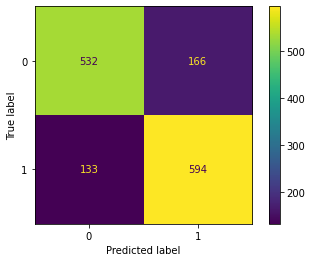

              precision    recall  f1-score   support

           0       0.80      0.76      0.78       698
           1       0.78      0.82      0.80       727

    accuracy                           0.79      1425
   macro avg       0.79      0.79      0.79      1425
weighted avg       0.79      0.79      0.79      1425



In [53]:
clf = XGBClassifier(**grid_search.best_params_).fit(x_train, y_train)

train_predictions = clf.predict(x_train)
accuracy = accuracy_score(y_train, train_predictions)
print("Accuracy train XGB: %.2f%%" % (accuracy * 100.0))

test_predictions = clf.predict(x_test)
accuracy = accuracy_score(y_test, test_predictions)
print("Accuracy test XGB: %.2f%%" % (accuracy * 100.0))
ConfusionMatrixDisplay.from_predictions(y_test, test_predictions)
plt.show()

print(classification_report(y_test,clf.predict(x_test)))

In [54]:
names = ['Random Forest', 'Logistic Regression', 'SGDC', 'SVC', 'NuSVC', 'Linear SVC', 'Desicion Tree Classifier', 'Extra Trees', 'XGB']

FOLDS=5
cv = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=10)

x_train2 = np.array(x_train)
y_train2 = np.array(y_train)


for clfi, name in zip([ensemble.RandomForestClassifier(), linear_model.LogisticRegressionCV(solver='sag',max_iter=3000), 
                       linear_model.SGDClassifier(), SVC(kernel='poly'), NuSVC(kernel='poly'), LinearSVC(max_iter=50000), 
                       DecisionTreeClassifier(criterion='entropy'), ExtraTreeClassifier(), XGBClassifier(**grid_search.best_params_)],names):
    print(clfi)
    avg_accuracy = 0
    for fold, (train_idx, val_idx) in enumerate(cv.split(x_train2, y_train2)):
        xi, yi = x_train2[train_idx], y_train2[train_idx]
        x_valid, y_valid = x_train2[val_idx], y_train2[val_idx]
        clfi = clfi.fit(xi, yi)

        test_predictions = clfi.predict(x_valid)
        accuracy = accuracy_score(y_valid, test_predictions)
        avg_accuracy +=accuracy
        print(f"Precisión test fold {fold}: {accuracy * 100.0 :.2f}" % ())

    avg_accuracy /= FOLDS
    print(f'Avg. accuracy = {avg_accuracy * 100}')

RandomForestClassifier()
Precisión test fold 0: 76.93
Precisión test fold 1: 80.44
Precisión test fold 2: 76.67
Precisión test fold 3: 77.70
Precisión test fold 4: 79.19
Avg. accuracy = 78.18541965097114
LogisticRegressionCV(max_iter=3000, solver='sag')
Precisión test fold 0: 77.63
Precisión test fold 1: 79.91
Precisión test fold 2: 77.11
Precisión test fold 3: 78.40
Precisión test fold 4: 79.19
Avg. accuracy = 78.44870076860279
SGDClassifier()
Precisión test fold 0: 77.02
Precisión test fold 1: 79.39
Precisión test fold 2: 77.19
Precisión test fold 3: 77.26
Precisión test fold 4: 79.19
Avg. accuracy = 78.00990404017065
SVC(kernel='poly')
Precisión test fold 0: 77.81
Precisión test fold 1: 80.09
Precisión test fold 2: 75.79
Precisión test fold 3: 77.00
Precisión test fold 4: 78.93
Avg. accuracy = 77.92209232475395
NuSVC(kernel='poly')
Precisión test fold 0: 78.33
Precisión test fold 1: 80.26
Precisión test fold 2: 75.53
Precisión test fold 3: 77.52
Precisión test fold 4: 79.10
Avg. acc

## Generar la salida para entregar

In [56]:
test_df = pd.read_csv('test.csv')

In [57]:
test_df

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,415,Europa,True,NaN,55 Cancri e,34.0,False,0.0,0.0,0.0,0.0,0.0,Minopus Taptiritty
1,8663,Earth,True,G/1489/S,PSO J318.5-22,13.0,False,0.0,0.0,0.0,0.0,0.0,Chrisa Francock
2,4524,Earth,False,G/776/P,TRAPPIST-1e,44.0,False,22.0,1.0,0.0,864.0,0.0,Elinda Miley
3,8246,Earth,False,E/577/S,PSO J318.5-22,63.0,False,0.0,0.0,80.0,0.0,2322.0,Karley Goods
4,2935,Europa,False,B/117/S,55 Cancri e,10.0,False,0.0,0.0,0.0,0.0,0.0,Arkard Sechausive
...,...,...,...,...,...,...,...,...,...,...,...,...,...
865,5996,Mars,False,F/1212/S,TRAPPIST-1e,54.0,False,676.0,0.0,231.0,379.0,0.0,Anch Perta
866,5478,Earth,True,G/947/S,TRAPPIST-1e,58.0,False,0.0,0.0,0.0,0.0,0.0,Hughy Hessey
867,6760,Earth,True,G/1148/P,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Heidie Kimpson
868,1437,Earth,False,F/293/S,TRAPPIST-1e,18.0,False,765.0,0.0,13.0,0.0,0.0,Herina Oconley


Para poder evaluar nuestra predicción los datos de prueba deben tener exactamente el mismo tratamiento que los datos de entrenamiento

In [58]:
test_df = test_df.dropna(axis=0, subset=['CryoSleep', 'VIP', 'HomePlanet', 'Destination'])

In [59]:
test_df[imputer_cols] = imputer.fit_transform(test_df[imputer_cols])

PassengerId = test_df['PassengerId']
test_df.drop(['PassengerId','Cabin', 'Name'], inplace=True, axis=1)

for col in label_cols:
    test_df[col] = test_df[col].astype(str)
    test_df[col] = LabelEncoder().fit_transform(test_df[col])

cols = test_df.columns
test_df = StandardScaler().fit_transform(test_df)
test_df = pd.DataFrame(test_df, columns=cols)

Generamos la salida

In [61]:
test_id = PassengerId
test_pred = clf.predict(test_df)


In [63]:
submission = pd.DataFrame(list(zip(test_id, test_pred)), columns=["PassengerId", "Transported"])
submission.to_csv("sample_submission.csv", header=True, index=False)
submission

,PassengerId,Transported
0,415,1
1,8663,1
2,4524,0
3,8246,0
4,2935,1
...,...,...
785,5996,0
786,5478,1
787,6760,1
788,1437,0
